<h1 style="text-align: center;">Risques extrêmes en finance de marché</h1>


### Introduction

La modélisation du risque de marché extrême est un domaine crucial pour évaluer les événements rares, mais potentiellement catastrophiques, qui peuvent affecter les marchés financiers. 

Les méthodes traditionnelles de simulation, telles que le Monte Carlo naïf, sont couramment utilisées pour estimer la distribution des pertes et des gains. Cependant, bien que cette approche soit utile pour simuler un large éventail de scénarios, elle présente des limitations importantes lorsqu'il s'agit de capturer correctement les événements rares. 

En effet, le Monte Carlo naïf ne permet pas de visualiser efficacement les probabilités associées à ces événements extrêmes, car les simulations ne sont pas suffisamment nombreuses pour refléter fidèlement la faible probabilité de tels événements. 

Par conséquent, une approche plus sophistiquée est nécessaire pour modéliser avec précision le risque de marché extrême et fournir des évaluations fiables des risques associés à des événements peu fréquents mais potentiellement dévastateurs.




In [193]:
#modules importation
import numpy as np
import scipy.stats as sps 
import matplotlib.pyplot as plt
import math as m
import seaborn as sns


### 1 – Modélisation du portefeuille


In [195]:
#Benchmark values
S_0=100
K=100
var=2
sigma = np.sqrt(var)
vars=[2 for i in range(10)]
S_s=[100 for i in range(10)]
alpha=np.array([10 for i in range(10)])
beta=np.array([5 for i in range(10)])

On supposera que le cours d’action est modélisé par un mouvement brownien géométrique :

$$
S_t = S_0 e^{-\frac{1}{2} \sigma^2 t + \sigma W_t}
$$

En particulier, $S_t$ est solution de l’équation différentielle stochastique (1) :

$$
dS_t = \sigma S_t dW_t
$$

de prix initial $S_0$. Précisons les notations :

- $W = (W_t)_{t \geq 0} $ est un mouvement brownien, c’est-à-dire un processus continu à temps continu, avec $W_0 = 0$, des accroissements indépendants et stationnaires, dont les accroissements $W_{t+h} - W_t$ suivent une loi gaussienne $N(0, h)$.

Le rendement de S (variation relative) sur un court intervalle de temps $h \ll 1$ peut s’écrire :

$$
\frac{S_{t+h} - S_t}{S_t} \approx \sigma (W_{t+h} - W_t)
$$

Ainsi, $\sigma^2$ mesure la variance des rendements instantanés (appelée aussi volatilité).


In [196]:
def Brownian_motion(t,h=0.1,n_paths=1000):
    '''Cette fonction génère plusieurs simulations de mouvement Brownien
    args:
    - t: l'instant de fin de la simulation
    - h: pas de discrétisation
    - n_paths: nombre de simulations
    returns:
    - n_paths simulations de mouvement Brownien jusqu'à l'instant t'''
    
    n_steps=int(t/h)
    dW=np.random.normal(0, np.sqrt(h/365), size=(n_paths, n_steps))
    result=np.zeros((n_paths, n_steps+1))
    result[:,1:]=np.cumsum(dW, axis=1)
    return result
    

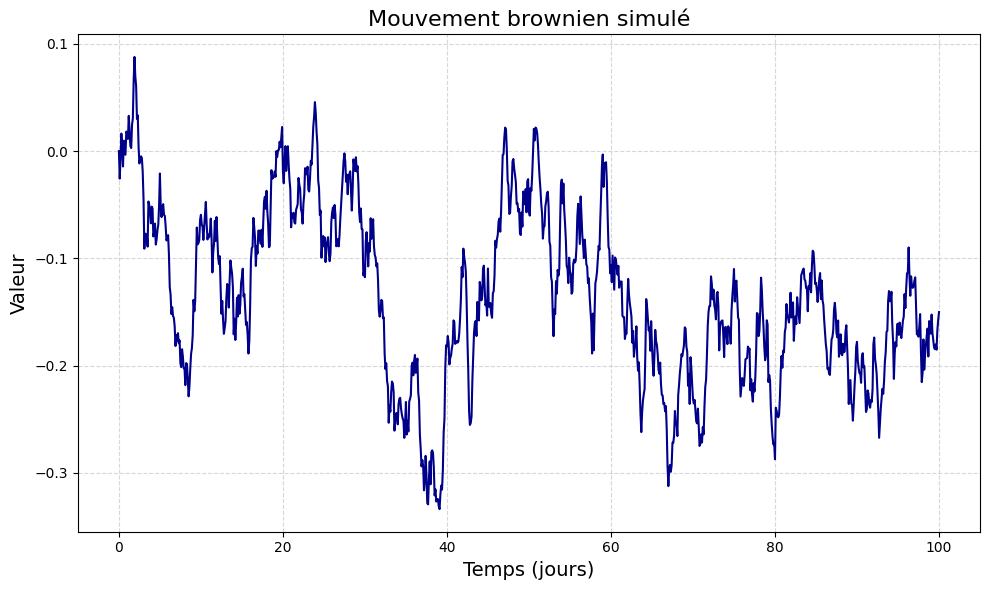

In [197]:
Brownian=Brownian_motion(100)
time=np.linspace(0,100,1001)
plt.figure(figsize=(10, 6))
sns.lineplot(x=time, y=Brownian[0], color='darkblue')
plt.title("Mouvement brownien simulé", fontsize=16)
plt.xlabel("Temps (jours)", fontsize=14)
plt.ylabel("Valeur", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [198]:
def Stock_price(S,var,Brownian,h=0.001):
    '''Cette fonction génère plusieurs simulations de prix d'action
    args:
    - S: prix initial de l'action
    - var: volatilité de l'action
    - Brownian: plusieurs simulation de mouvement Brownien
    - h: pas de discrétisation
    returns:
    - plusieurs simulations de prix d'action jusqu'à un instant donné'''
    
    n_paths,n_steps = Brownian.shape
    times=np.arange(n_steps) * h / 365
    drift=(-0.5 * var**2)*times
    diffusion =var*Brownian
    log_S=drift + diffusion
    S=S * np.exp(log_S)
    return S
    

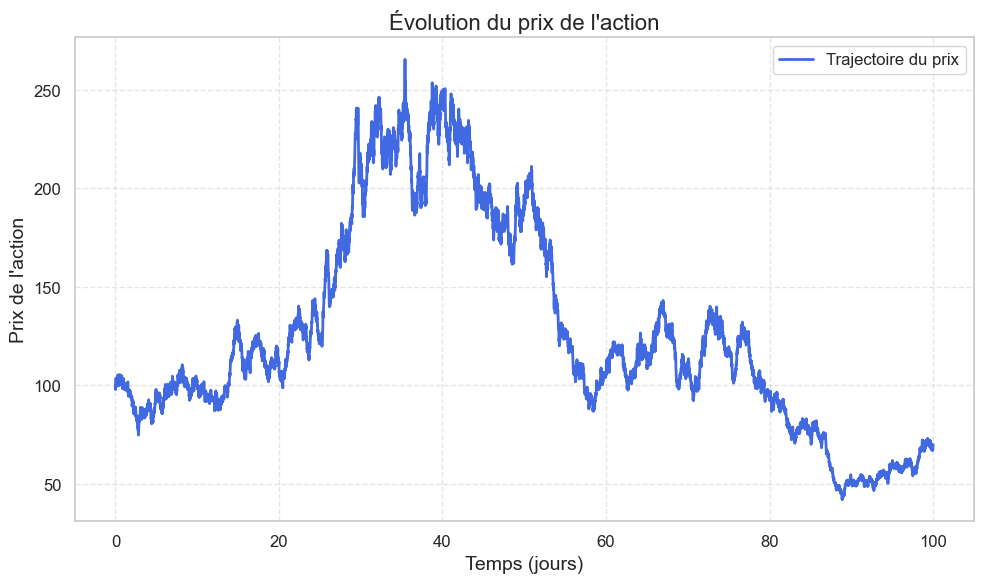

In [205]:
Brownian=Brownian_motion(100,0.01)
Stock=Stock_price(S_0,var,Brownian)
time=np.linspace(0,100,10001)

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
plt.plot(time, Stock[0], color='royalblue', linewidth=2, label='Trajectoire du prix')

plt.title("Évolution du prix de l'action", fontsize=16)
plt.xlabel("Temps (jours)", fontsize=14)
plt.ylabel("Prix de l'action", fontsize=14)

plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


Dans ce modèle négligeant les taux d’intérêt, le prix $Call(t, S_t)$ de l’option d’achat à la date t avant maturité T, lorsque le sous-jacent vaut $S_t$, est donné par la formule de Black & Scholes :

$$
Call(t, S_t) = S_t N[d^+((T - t), S_t, K)] - K N[d^-((T - t), S_t, K)]
$$

avec

$$
d^\pm(\tau, x, y) = \frac{1}{\sigma \sqrt{\tau}} \left( \ln\left(\frac{x}{y}\right) \pm \sigma \sqrt{\tau} \right)
$$

où $N$ est la fonction de répartition de la loi normale centrée réduite.

Le prix $Put(t, S_t)$ du Put a une forme symétrique :

$$
Put(t, S_t) = K N[d^+((T - t), K, S_t)] - S_t N[d^-((T - t), K, S_t)].
$$


In [200]:
def Call_price(var,K,T,Stock,h=0.01):
    '''Cette fonction génère plusieurs simulations de prix du Call
    args:
    - Stock: plusieurs simulations de prix de l'action
    - var: volatilité de l'action
    - K: prix de l'exercice de l'option
    - T: maturité de l'option
    - h: pas de discrétisation
    returns:
    - plusieurs simulations de prix du Call jusqu'à un instant donné'''
    
    n_steps=Stock.shape[1]
    times=np.arange(n_steps)*h
    sqrt_tau=np.sqrt((T-times)/365)
    d_p=1/(var*sqrt_tau)*np.log(Stock/K)+0.5*var*sqrt_tau
    d_n=1/(var*sqrt_tau)*np.log(Stock/K)-0.5*var*sqrt_tau
    normal_p=sps.norm.cdf(d_p,0,1)
    normal_n=sps.norm.cdf(d_n,0,1)
    result=Stock*normal_p-K*normal_n
    return result

def Put_price(var,K,T,Stock,h=0.01):
    '''Cette fonction génère plusieurs simulations de prix du Put
    args:
    - Stock: plusieurs simulations de prix de l'action
    - var: volatilité de l'action
    - K: prix de l'exercice de l'option
    - T: maturité de l'option
    - h: pas de discrétisation
    returns:
    - plusieurs simulations de prix du Put jusqu'à un instant donné'''
    n_steps=Stock.shape[1]
    times=np.arange(n_steps)*h
    sqrt_tau=np.sqrt((T-times)/365)
    d_p=1/(var*sqrt_tau)*np.log(Stock/K)+0.5*var*sqrt_tau
    d_n=1/(var*sqrt_tau)*np.log(Stock/K)-0.5*var*sqrt_tau
    normal_p=sps.norm.cdf(d_p,0,1)
    normal_n=sps.norm.cdf(d_n,0,1)
    result=K*normal_p-Stock*normal_n
    return result

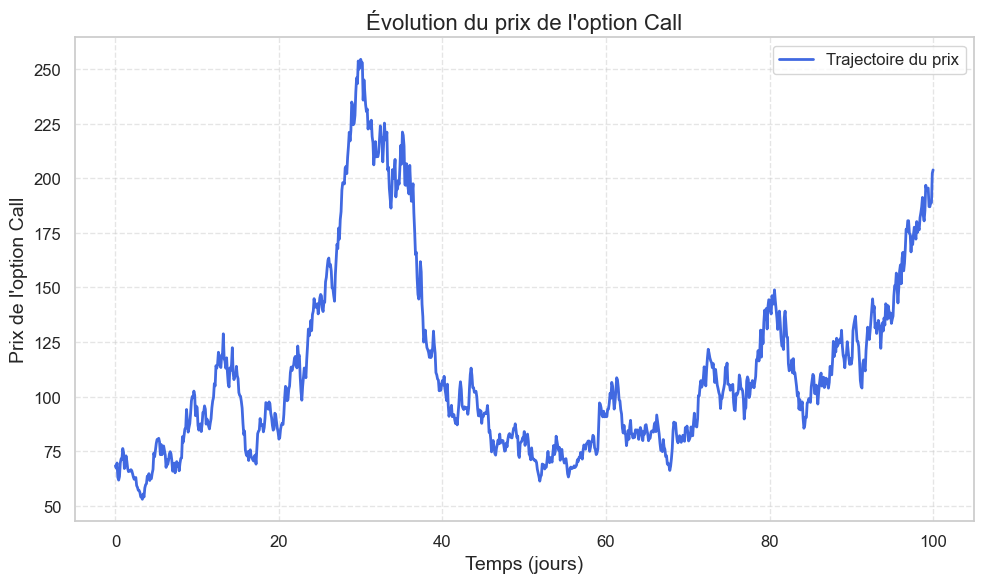

In [208]:
Brownian=Brownian_motion(100,0.1)
Stock=Stock_price(S_0,var,Brownian)
Calls=Call_price(var,K,365,Stock)
time=np.linspace(0,100,1001)
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
plt.plot(time,Calls[0], color='royalblue', linewidth=2, label='Trajectoire du prix')

plt.title("Évolution du prix de l'option Call", fontsize=16)
plt.xlabel("Temps (jours)", fontsize=14)
plt.ylabel("Prix de l'option Call", fontsize=14)

plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

On considère un portefeuille combinant des calls/puts sur \( I_0 \) actions différentes. La valeur \( V_t \) du portefeuille est donc donnée par :

$$
V_t = \sum_{i=1}^{I_0} \left( \alpha_i \text{Call}_i(t, S_i^t) + \beta_i \text{Put}_i(t, S_i^t) \right)
$$

avec $(S_t^i)_{t \geq 0}$ étant la solution de l'équation (1), étant donné un mouvement brownien $(W_i)_{t \geq 0}$ et un écart-type des rendements $\sigma_i$, et $\alpha_i, \beta_i \in \mathbb{R}$, $i \in \{1, \dots, I_0\}$.

In [211]:
def Portfolio_Value(alpha,beta,t,T,S,K,vars,h=0.01,n_paths=1000):
    '''Cette fonction génère plusieurs simulations de la valeur du portefeuille
    args:
    - alpha: part des options Call
    - beta: part des options Put
    - t: l'instant de fin de la simulation
    - K: prix de l'exercice des options
    - T: maturité des options
    - S: prix initiaux des actions
    - vars: volatilité des actions
    - h: pas de discrétisation
    - n_paths: nombre des simulations
    returns:
    - plusieurs simulations de la valeur du portefeuille jusqu'à un instant donné'''
    
    n_stocks=len(S)
    n_steps=int(t/h)+1
    result=np.zeros((n_paths,n_steps))
    for i in range(n_stocks):
        Brownian=Brownian_motion(t,h,n_paths)
        Stock_paths=Stock_price(S[i],vars[i],Brownian,h)
        call_paths=Call_price(vars[i],K,T,Stock_paths,h)
        put_paths=Put_price(vars[i],K,T,Stock_paths,h)
        result+=alpha[i]*call_paths+beta[i]*put_paths
    return result

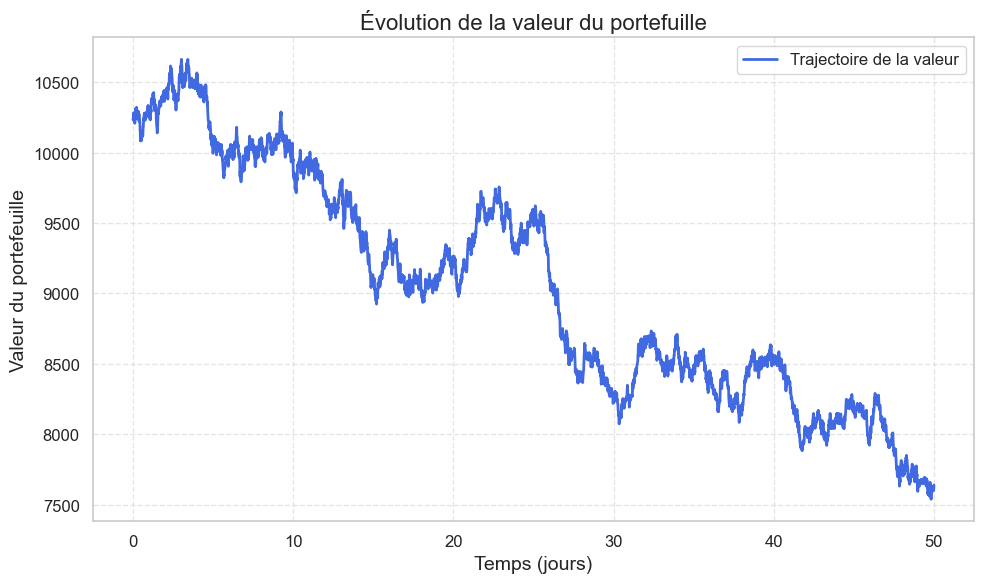

In [220]:
Portfolio=Portfolio_Value(alpha,beta,50,365,S_s,K,vars)[0]
time=np.linspace(0,50,5001)
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
plt.plot(time,Portfolio, color='royalblue', linewidth=2, label='Trajectoire de la valeur')

plt.title("Évolution de la valeur du portefuille", fontsize=16)
plt.xlabel("Temps (jours)", fontsize=14)
plt.ylabel("Valeur du portefeuille", fontsize=14)

plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

### 2 – Estimations

On commence tout d'abord par estimerla fonction de répartition du portefuille en utilisant la méthode de Monte Carlo naif

In [265]:
def empirical_cdf(alpha,beta,t,T,S,K,vars,x,h=0.01,n_paths=1000):
    result=Portfolio_Value(alpha,beta,t,T,S,K,vars,h,n_paths)[:,-1]
    result=np.mean(result<=x)
    return result

def empirical_ppf(alpha,beta,t,T,S,K,vars,x,h=0.01,n_paths=1000):
    dx=100
    result=Portfolio_Value(alpha,beta,t,T,S,K,vars,h,n_paths)[:,-1]
    result=(np.mean(result<=x+dx)-np.mean(result<=x))/dx
    return result

#Cette deuxième fonction est beaucoup plus efficace pour des raisons de complexité temporelle
def empirical_cdf_MCMC(Portfolio,x):
    result=Portfolio[:,-1]
    result=np.mean(result<=x)
    return result
    
def empirical_ppf_MCMC(Portfolio,x):
    dx=100
    result=Portfolio[:,-1]
    result=(np.mean(result<=x+dx)-np.mean(result<=x))/dx
    return result

In [266]:
x=10000
F=empirical_cdf(alpha,beta,10,365,S_s,K,vars,x)
print("la fonction de réparttion en "+str(x)," est égale à: "+str(F))
df=empirical_ppf(alpha,beta,10,365,S_s,K,vars,x)
print(df)


la fonction de réparttion en 10000  est égale à: 0.484
0.0004999999999999999


Une deuxième expérience est la calcul de la moyenne de notre portfeuille à tout instant.
Autrement dit, on détermine $(\mathbb{E}(V_t))_{t \geq 0}$ en utilisant la méthode de Monte Carlo naif.

In [217]:
def Portfolio_mean(alpha,beta,t,T,S,K,vars,h=0.1,n_paths=1000):
    result=Portfolio_Value(alpha,beta,t,T,S,K,vars,h,n_paths)
    result=np.mean(result,axis=0)
    return result
        

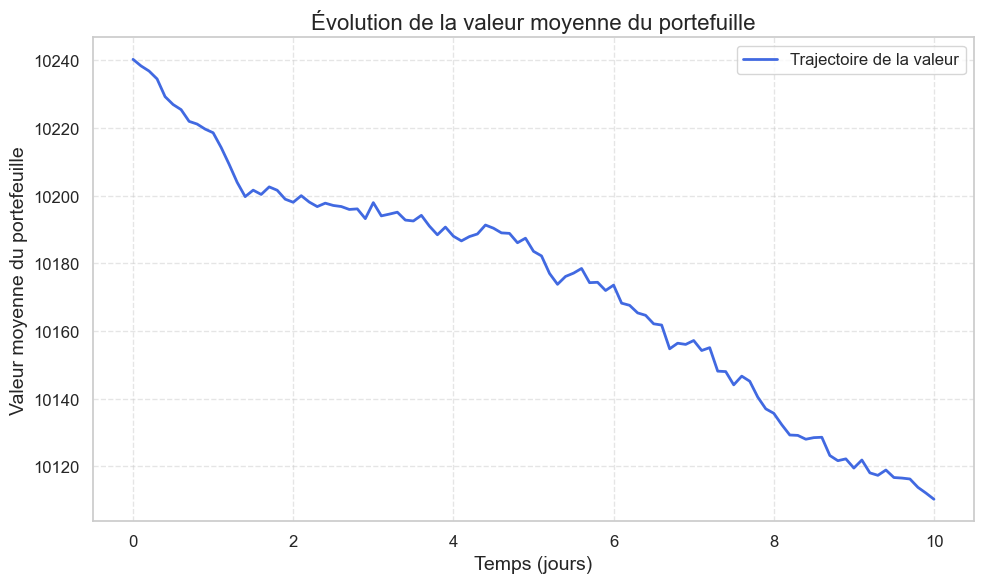

In [222]:
Mean=Portfolio_mean(alpha,beta,10,365,S_s,K,vars)
time=np.linspace(0,10,101)
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
plt.plot(time,Mean, color='royalblue', linewidth=2, label='Trajectoire de la valeur')

plt.title("Évolution de la valeur moyenne du portefuille", fontsize=16)
plt.xlabel("Temps (jours)", fontsize=14)
plt.ylabel("Valeur moyenne du portefeuille", fontsize=14)

plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

Pour montrer la limite de la méthode de Monte Carlo naif, on simule la probabilité que la valeur du portefeuille soit supérieure où égale à une contsante * sa moyenne. $\\$
C'est à dire qu'on estime $\mathbb{P}(V_t \geq bound*\mathbb{E}(V_t))$

In [223]:
def Probability_above_average(alpha,beta,t,T,S,K,vars,bound=1,h=0.1,n_paths=10000):
    result=Portfolio_Value(alpha,beta,t,T,S,K,vars,h,n_paths)
    result=np.mean(result > bound * Mean, axis=0)
    return result
        

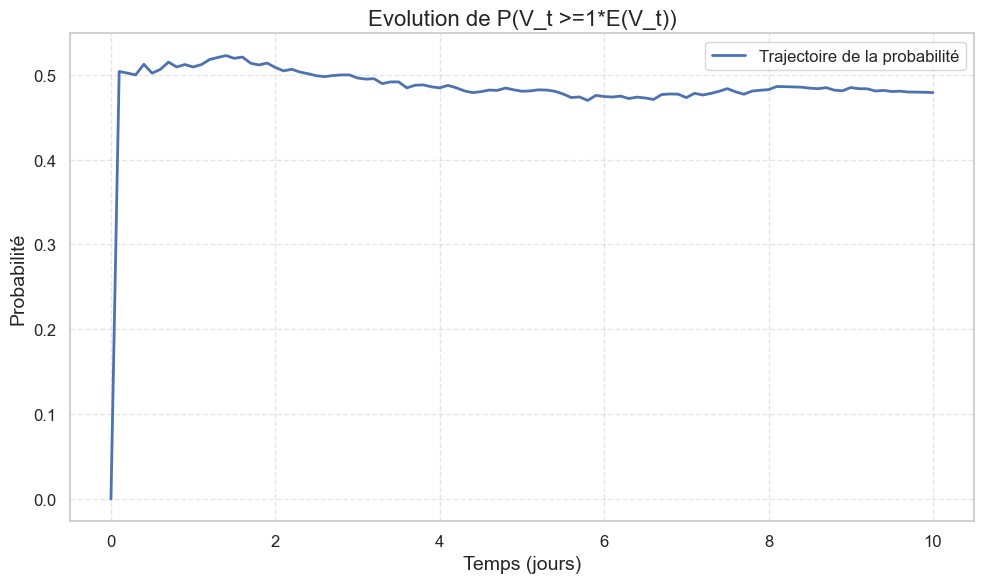

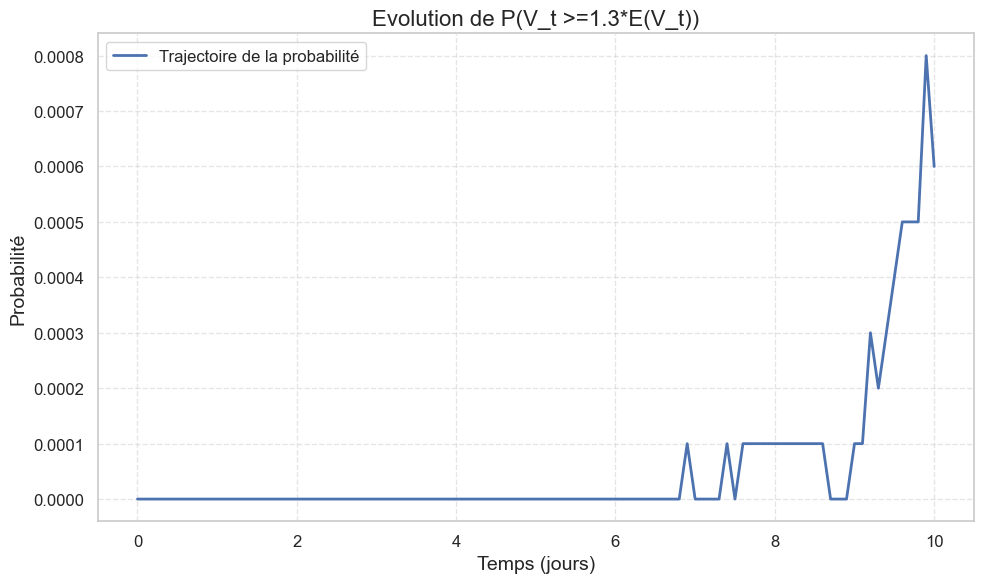

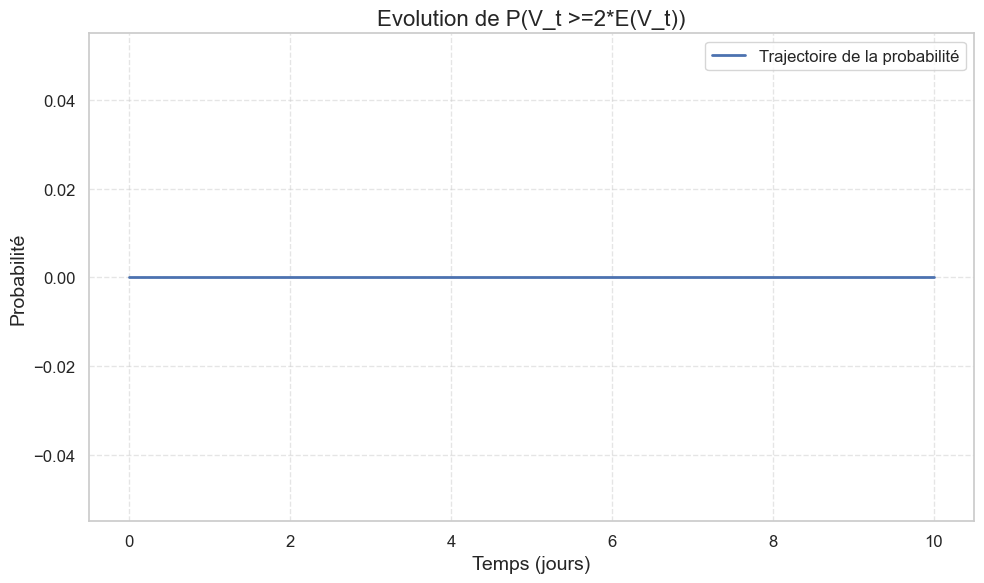

In [234]:
for i in [1,1.3,2]:
    proba=Probability_above_average(alpha,beta,10,365,S_s,K,vars,bound=i)
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    plt.plot(time,proba, linewidth=2, label='Trajectoire de la probabilité')

    plt.title("Evolution de P(V_t >={}*E(V_t))".format(i),fontsize=16)
    plt.xlabel("Temps (jours)", fontsize=14)
    plt.ylabel("Probabilité", fontsize=14)

    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

On remarque que déjà pour bound=1.3 cette méthode a du mal a estimer cette probabilité. Alors que pour bound=2 cet algorithme génère 0 comme estimation de la probabilité vu qu'il s'agit d'un évènement rare.

On estime maintenant la fonction quantile qu'on utilisera pour l'algorithme de MCMC. On utilisera les statistiques d'ordre vus en cours.

In [227]:
def empirical_quantile(alpha,beta,t,T,S,K,vars,seuil=0.1,h=0.1,n_paths=1000):
    result=Portfolio_Value(alpha,beta,t,T,S,K,vars,h,n_paths)
    result=np.quantile(result,1-seuil,axis=0)
    return result

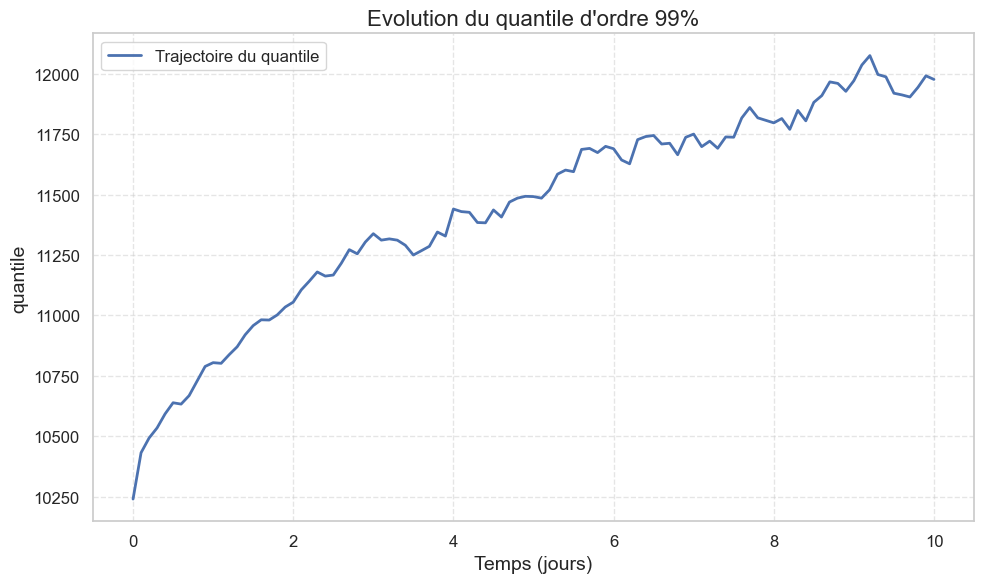

In [232]:
quantiles=empirical_quantile(alpha,beta,10,365,S_s,K,vars,seuil=0.01)
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
plt.plot(time,quantiles, linewidth=2, label='Trajectoire du quantile')

plt.title("Evolution du quantile d'ordre {}%".format(99),fontsize=16)
plt.xlabel("Temps (jours)", fontsize=14)
plt.ylabel("quantile" , fontsize=14)

plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

Maintenant, on utilise la méthode de splitting en utilisant MCMC pour simuler les événements rares que la méthode de Monte Carlo naif a échoué à détecter. L'idée est d'appliquer l'algorithme de MCMC sur l'estimation de la densité de la valeur du portefeuille.

In [275]:
def Probability_above_average_MCMC(alpha,beta,t,T,S,K,vars,seuil=0.1,bound=1,h=0.1,n=1000):
    levels=empirical_quantile(alpha,beta,t,T,S,K,vars,seuil=seuil)
    levels=[[level] for level in levels]
    result=np.array([])
    it=1
    for i in range(len(levels)-1,len(levels)):
    #for i in range(1,len(levels)):
        Portfolio=Portfolio_Value(alpha,beta,i*h,T,S,K,vars,h,n)
        Mean=Portfolio_mean(alpha,beta,i*h,T,S,K,vars)
        print("Level {}: {}".format(it,levels[i][-1]))
        while levels[i][-1]<bound*Mean[-1]:
            it+=1
            starting_point=levels[i][-1]
            X=[starting_point]
            accepted=0
            for _ in range(n):
                proposal_std=15
                if accepted/n<0.2:
                    proposal_std*=0.9
                elif accepted/n>0.5:
                    proposal_std*=1.1
                transition_point=np.random.normal(X[-1],proposal_std)
                cdf_new = empirical_cdf_MCMC(Portfolio, transition_point)
                cdf_old = empirical_cdf_MCMC(Portfolio, X[-1])
                a = min(1, (1 - cdf_new) / (1 - cdf_old + 1e-12))
                u=np.random.random()
                next_point=transition_point*int(u<=a)+X[-1]*int(u>a)
                accepted+=int(u<=a)
                next_point=next_point*int(next_point>=levels[i][-1])+X[-1]*int(next_point<levels[i][-1])
                X.append(next_point)
            X=np.array(sorted(X[int(0.3 * len(X)):]))
            #X=np.array(sorted(X))
            levels[i].append(X[int(np.ceil(len(X)*(1-seuil)))-1])
            print("Level {}: {}".format(it,levels[i][-1]))
            print("The biggest Markov chain value: {}".format(X[-1]))
        last_term=np.mean(X>bound*Mean[-1])
        result=np.append(result,last_term*seuil**(len(levels[i])-1))
    return result

In [278]:
Probability_above_average_MCMC(alpha,beta,10,365,S_s,K,vars,seuil=0.2,bound=1.4,n=10000)



Level 1: 10848.149483255153
Level 2: 11168.514380458153
The biggest Markov chain value: 11723.660062385872
Level 3: 11723.630183529966
The biggest Markov chain value: 12640.934366816804
Level 4: 12454.229674014836
The biggest Markov chain value: 12870.49533826726
Level 5: 12813.352424510733
The biggest Markov chain value: 13279.447575367474
Level 6: 13153.20370237115
The biggest Markov chain value: 13447.447275676966
Level 7: 13349.839144458105
The biggest Markov chain value: 13452.219379060567
Level 8: 13433.037806042035
The biggest Markov chain value: 13452.187663816432
Level 9: 13448.528361522489
The biggest Markov chain value: 13452.206852723855
Level 10: 13451.51532835434
The biggest Markov chain value: 13452.201227140078
Level 11: 13451.998273160632
The biggest Markov chain value: 13452.208735811584
Level 12: 13452.16103997003
The biggest Markov chain value: 13452.224443192543
Level 13: 13452.211172515108
The biggest Markov chain value: 13452.218211851692
Level 14: 13452.21683761

KeyboardInterrupt: 

In [294]:
def Probability_above_average_MCMC(alpha,beta,t,T,S,K,vars,seuil=0.2,bound=1.4,h=0.1,n=10000,max_levels=20):
    result=[]

    # Étape 1: Simule les trajectoires de portefeuille
    Portfolio=Portfolio_Value(alpha,beta,t,T,S,K,vars,h,n)
    Values=Portfolio[:,-1]
    Mean=np.mean(Values)
    
    print(f"Target = {bound:.2f} × mean = {bound * Mean:.4f}")
    
    # Étape 2: Premier niveau
    #level=np.quantile(Values,1-seuil)
    level=empirical_quantile(alpha,beta,t,T,S,K,vars,seuil=seuil)[-1]
    levels=[level]
    prob=1.0
    iteration=0
    
    while level<bound*Mean:
        iteration+=1
        print(f"Level {iteration}: {level:.4f}")
        
        # Sélectionne les survivants
        survivors=Values[Values>=level]
        
        # Génère les nouvelles propositions (MCMC with mixed proposals)
        new_samples=[]
        std_local = np.std(survivors)
        for _ in range(n):
            base=np.random.choice(survivors)
            
            if np.random.rand()<0.9:
                # Local move
                proposal=np.random.normal(base, std_local * 0.5)
            else:
                # Global jump
                proposal = np.random.uniform(level,level+3*std_local)
            
            # Accepte si le point est au-dessus du niveau précédent
            if proposal>=level:
                new_samples.append(proposal)
            else:
                new_samples.append(base)  # reste sur place
        
        new_samples=np.array(new_samples)
        Values=new_samples
        
        # Nouveau niveau
        new_level=np.quantile(Values,1-seuil)
        if abs(new_level-level) < 1e-5:
            print("Stagnation détectée. Stop.")
            return np.array([0.0])
        
        level=new_level
        levels.append(level)
        prob*=seuil
        
        if iteration>=max_levels:
            print("Trop de niveaux. Stop.")
            break
    
    # Dernière estimation conditionnelle
    final_prob=np.mean(Values>bound*Mean)
    total_prob=prob*final_prob
    print(f"Estimation finale: P(V_T > {bound} * mean) ≈ {total_prob:.6e}")
    
    return np.array(total_prob)

In [298]:
Probability_above_average_MCMC(alpha,beta,10,365,S_s,K,vars,seuil=0.1,bound=1.3,n=10000)

Target = 1.30 × mean = 13157.7173
Level 1: 11155.7419
Level 2: 12180.1993
Level 3: 13051.9481
Estimation finale: P(V_T > 1.3 * mean) ≈ 7.119000e-04


array(0.0007119)